In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import scipy.stats as sts

In [2]:
def read_reference_energies():
    folders = glob.glob('naphtalene/validation-molpro/*/')
    res = []
    for folder in folders:
        this = {}
        
        basename = folder.split('/')[-2]
        this['label'] = basename.split('-')[-1]
        this['nbn'] = int(basename.split('-')[1])
        
        try:
            with open(folder+ 'direct.out') as fh:
                lines = fh.readlines()
            this['energy'] = float(lines[-6].strip().split()[-1])
            this['nn'] = float([_ for _ in lines if 'Nuclear energy' in _][0].strip().split()[-1])
        except:
            with open(folder+ 'run.log') as fh:
                lines = fh.readlines()
            this['energy'] = float(lines[-7].strip().split()[-1])
            this['nn'] = float([_ for _ in lines if 'Nuclear repulsion energy' in _][0].strip().split()[-1])
        
        res.append(this)
    return pd.DataFrame(res)
df = read_reference_energies()

In [3]:
def read_report(fn, restrict):
    with open(fn) as fh:
        lines = fh.readlines()
    
    order = []
    groups = []
    count = 0
    started = False
    if restrict is None:
        started = True
    for line in lines:
        # check for relevant section
        if restrict is not None:
            if "stoichiometry" in line:
                nbn = len([_ for _ in line if _ == "5"])
                if nbn == restrict:
                    started = True
                else:
                    started = (restrict is None)
        if not started:
            continue
        if "Found:" in line:
            label = ''.join(line.split('[')[1].split(']')[0].replace(' ', '').split(','))
            label = label.replace('5', 'B').replace('6', 'C').replace('7', 'N')
            order.append(label)
            count += 1
        
        if "Group energy" in line:
            groups.append(count)
            count = 0
    return order, groups[1:]
def bond_count(label):
    bonds = {'BH': 0, 'CH': 0, 'HN': 0, 'BB': 0, 'BC': 0, 'BN': 0, 'CC': 0, 'CN': 0, 'NN': 0, }
    infile = [(4, 14), (3, 13), (3, 9), (2, 3), (4, 9), (4, 5), (5, 15), (2, 12), (8, 9), (1, 2), (5, 6), (1, 11), (0, 1), (6, 16), (6, 7), (7, 8), (0, 8), (7, 17), (0, 10)]
    for letter in label[:-2]:
        k = ''.join(sorted([letter, "H"]))
        bonds[k] += 1
    
    for a,b in infile:
        if a > 9 or b > 9:
            continue
        k = ''.join(sorted([label[_] for _ in (a, b)]))
        bonds[k] += 1
    return bonds
def build_mat(group, bondorder):
    A = []
    for label in group:
        counts = bond_count(label)
        A.append([counts[_] for _ in bondorder])
    return np.array(A)

def solve_group(group, bondorder):
    A = build_mat(group, bondorder)
    if 0 in np.sum(A, axis=0):
        return None
    coeffs = np.linalg.lstsq(A, np.zeros(len(A))+100, rcond=None)[0]
    return coeffs

def rate_coefficients(coeffs, A, b):
    return sts.spearmanr(np.dot(A, coeffs), b).correlation

def rerank(report, df, restrict=4, get_coeffs=False):
    # read groups
    bondorder = ['BB', 'BC', 'BH', 'BN', 'CC', 'CH', 'CN', 'HN', 'NN']
    ranking, groupsizes = read_report(report, restrict)
    A = build_mat(ranking, bondorder)
    b = []
    bnn = []
    for label in ranking:
        nolabel = label.replace('B', '5').replace('C', '6').replace('N', '7')
        b.append(df.query("label == @nolabel").energy.values[0])# - df.query("label == @nolabel").nn.values[0] )
        bnn.append(df.query("label == @nolabel").nn.values[0] )
    b = np.array(b)
    bnn = np.array(bnn)
    
    # split groups
    groups = []
    modranking = ranking[:]
    for chunk in groupsizes:
        groups.append(modranking[:chunk])
        modranking = modranking[chunk:]
    groups.append(modranking)
        
    # solve each group
    results = []
    sizes = []
    coefficients = []
    for group in groups:
        if len(group) <2:
            continue
        this = solve_group(group, bondorder)
        if this is not None and (this>0).all():
            sizes.append(len(group))
            results.append(rate_coefficients(this, A, b))
            
            # only insert if no duplicate
            for e in coefficients:
                delta = np.linalg.norm(e-this)
                if delta < 1e-10:
                    break
            else:
                coefficients.append(this)
    coeff = -np.array(coefficients).mean(axis=0)
    
    # rerank
    group_energies = []
    for group in groups:
        Atmp = build_mat(group, bondorder)
        group_energies.append(np.dot(Atmp, coeff).mean())
    
    reranked = []
    for idx in np.argsort(group_energies):
        reranked += groups[idx]
    
    # mix in NN ranking to ensure stability for few groups with valid regressions
    rankNN = np.argsort(bnn)
    newrank = np.array([reranked.index(_) for _ in ranking])
    N = len(coefficients)
    mixed = np.argsort(rankNN/N + newrank * N)
    reranked = [ranking[_] for _ in mixed]    
    
    # calculate original and improved score
    expected = list(df.sort_values("energy").label.str.replace('5', 'B').str.replace('6', 'C').str.replace('7', 'N').values)
    actual1 = [expected.index(_) for _ in ranking]
    xs = list(range(len(actual1)))
    original = sts.spearmanr(xs, actual1).correlation
    #plt.scatter(xs, actual)
    
    actual2 = [expected.index(_) for _ in reranked]
    xs = list(range(len(actual2)))
    improved = sts.spearmanr(xs, actual2).correlation
    
    #plt.scatter(xs, actual)
    
    if get_coeffs:
        return coeff
    return original, improved, len(groups)
COEFFS = rerank('scanning/2.2-CM', df.query("nbn==4"), 4, True)

In [5]:
def read_reranked_report(fn, coeff):
    bondorder = ['BB', 'BC', 'BH', 'BN', 'CC', 'CH', 'CN', 'HN', 'NN']
    ranking, groupsizes = read_report(fn, None)
    
    # split groups
    groups = []
    gnn = []
    gsize = []
    modranking = ranking[:]
    for chunk in groupsizes:
        gsize.append(chunk)
        groups.append(modranking[:chunk])
        gnn.append(len([_ for _ in modranking[0] if _ == 'B']))
        modranking = modranking[chunk:]
    groups.append(modranking)
        
    # rerank
    group_energies = []
    for group in groups:
        Atmp = build_mat(group, bondorder)
        group_energies.append(np.dot(Atmp, coeff).mean())
    
    reranked = []
    reranked_sizes = []
    for nbn in sorted(set(gnn))[::-1]:
        print (nbn)
        s = np.where(np.array(gnn) == nbn)[0]
        for idx in np.argsort(np.array(group_energies)[s]):
            reranked += groups[s[idx]]
            reranked_sizes.append(gsize[s[idx]])
    
    return reranked, reranked_sizes
#read_reranked_report('scanning/2.2-CM', COEFFS)

5
4
3
2
1
5
4
3
2
1


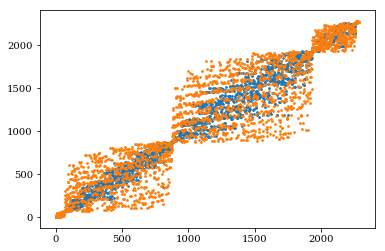

In [74]:
def visualise_report(fn, df):
    report, groups = read_reranked_report(fn,  COEFFS)
    df = df.query("nbn > 0").sort_values('energy')
    actual = [report.index(_.replace('5', 'B').replace('6', 'C').replace('7', 'N')) for _ in df.label.values]

    plt.scatter(range(len(actual)), actual, s=3, zorder=20, color='C0')
    
    report, groups = read_reranked_report_overlap(fn,  COEFFS)
    df = df.query("nbn > 0").sort_values('energy')
    actual = [report.index(_.replace('5', 'B').replace('6', 'C').replace('7', 'N')) for _ in df.label.values]

    plt.scatter(range(len(actual)), actual, s=3, zorder=20, color='C1')
    
visualise_report('scanning/2.2-CM', df)

In [73]:
def read_reranked_report_overlap(fn, coeff):
    bondorder = ['BB', 'BC', 'BH', 'BN', 'CC', 'CH', 'CN', 'HN', 'NN']
    ranking, groupsizes = read_report(fn, None)
    
    SCALE=5.
    
    # split groups
    groups = []
    gnn = []
    gsize = []
    modranking = ranking[:]
    for chunk in groupsizes:
        gsize.append(chunk)
        groups.append(modranking[:chunk])
        gnn.append(len([_ for _ in modranking[0] if _ == 'B']))
        modranking = modranking[chunk:]
    groups.append(modranking)
        
    # rerank
    enn_lookup = dict(zip(df.label.str.replace('5', 'B').str.replace('6', 'C').str.replace('7', 'N').values, df.nn.values))
    group_energies = []
    mol_es = []
    mols = []
    mols_nbn = []
    for group in groups:
        Atmp = build_mat(group, bondorder)
        group_energies.append(np.dot(Atmp, coeff).mean())
        
        for entry in group:
            mols.append(entry)
            mols_nbn.append(len([_ for _ in entry if _ == 'B']))
            mol_es.append(group_energies[-1] + SCALE*enn_lookup[entry])
    mols_nbn = np.array(mols_nbn)
    
    reranked = []
    for nbn in sorted(set(gnn))[::-1]:
        print (nbn)
        s = np.where(mols_nbn == nbn)[0]
        for idx in np.argsort(np.array(mol_es)[s]):
            reranked.append((np.array(mols)[s[idx]]))
    
    return reranked, []
q = read_reranked_report_overlap('scanning/2.2-CM', COEFFS)

5
4
3
2
1


In [67]:
q[0]

['BNBNNBNBNB',
 'BNBNBNNBNB',
 'BNBNBNBNBN',
 'BBNNNBNBNB',
 'BNBNNBBNNB',
 'BBNBBNNBNN',
 'BBNBBNBNNN',
 'BBNBNBNBNN',
 'BNBNNBNNBB',
 'BNBNNNBNBB',
 'NBBNNBNNBB',
 'BNNBBNNBBN',
 'BNBNBNNBBN',
 'BBNNBNNBNB',
 'BBNBNNNBNB',
 'BBNBBNNNBN',
 'BBNNBNBNNB',
 'BNNBNBBNBN',
 'BNBNNBNBBN',
 'BBNBNNBNNB',
 'BBNNBNBNBN',
 'BBNBNBNNNB',
 'BBNBNBNNBN',
 'BBNNNNBBNB',
 'BBNBNNBNBN',
 'BBBNNNNBNB',
 'BNBNNBBNBN',
 'BBNNNBBNNB',
 'BBBNNNBNNB',
 'BBBNNBNNNB',
 'NBBNNBBNBN',
 'BBNBBBNNNN',
 'BBNBNNBBNN',
 'BBBNBNNBNN',
 'BBNBNBBNNN',
 'BBBNBNBNNN',
 'BBBNNBNBNN',
 'BNNBNBNNBB',
 'BNBNBNNNBB',
 'BNBNNNNBBB',
 'BBNNNBNNBB',
 'BBNNNNBNBB',
 'BNNNNBBNBB',
 'BBNNBNNBBN',
 'BBNBBNNNNB',
 'BBNBNNNBBN',
 'BBNNBBNNBN',
 'BBNNNBNBBN',
 'BBBNBNNNNB',
 'BBBNBNNNBN',
 'BBNNNBBNBN',
 'BBBNNBNNBN',
 'BBBNNNBNBN',
 'BBBBBNNNNN',
 'BBBNBBNNNN',
 'BBBNNNBBNN',
 'BBBBNBNNNN',
 'BBBNNBBNNN',
 'BNNBBNNNBB',
 'BBNNBNNNBB',
 'BBNNNNNBBB',
 'BBNBNNNNBB',
 'BBBNNNNNBB',
 'BBNNNNBBBN',
 'BBBNNNNBBN',
 'BBBBNNNNBN',
 'BNBNCCNB